In [1]:
import random
import rpy2.robjects as robjects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from sklearn.metrics import average_precision_score
from signature_estimation_py.signature_estimation import signature_estimation_qp

Unable to determine R home: [WinError 2] The system cannot find the file specified
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [2]:
data = pd.read_table("data/cosmic-signatures.tsv")
signatures = data.iloc[:, 0]
data = data.iloc[:, 1:]

### Preprocessing Data

In [3]:
def rds_to_np_array(rds_filepath):
    '''
    Reads an rds file into a numpy array 
    
    params:
        rds_filepath (str) - Filepath of the rds file we want to read into a numpy array
    return:
        numpy.ndarray containing rds array data 
    '''
    raw_data = robjects.r['readRDS'](rds_filepath)
    processed_data = np.array(raw_data)
    
    return processed_data

def get_activity_dict(exposures, signature_names):
    '''
    Gets active dictionary for each signature
    ''' 
    activity_dict = {}
    exposure_percentages = (exposures.T / np.sum(exposures, axis = 1)) #num signatures x num samples
    
    for index in range(exposure_percentages.shape[0]):
        signature_name = signature_names[index]
        exposure_percent = exposure_percentages[index]
        
        active_tumors = np.where(exposure_percent > .05)[0]
        inactive_tumors = np.where(exposure_percent <= .05) [0]
        activity_dict[signature_name] = (active_tumors, inactive_tumors)
    
    return activity_dict

### Scoring Functions

In [4]:
def score_window(mutation_counts, signature_name, signature_vector, activity_dict, alpha = .5):
    '''
    Scores a window using contrastive projection scores as heuristic
    
    params:
        mutation_counts (numpy.ndarray) - (num tumors x 96) dimensional vector of mutation counts in the window we are scoring
        signature_name (str) - The name of the signature vector we are estimating exposures for. Should look like 'Signature x'
        signature_vector (numpy.ndarray) - 96 dimensional vector representing the mutation signature
        activity_dict (dict) - Dictionary mapping signature names to a tuple of the form (active sample indices, inactive sample indices)
        alpha (float) - downweighting parameter
        
    return:
        score of the window
    '''
    c, q = mutation_counts, signature_vector
    scores = 1 / np.linalg.norm(q) * (c @ q) # (num tumors,) shaped array
    scores = scores ** alpha
    
    active_indices = activity_dict[signature_name][0]
    inactive_indices = activity_dict[signature_name][1]
    
    active_scores = scores[active_indices] 
    inactive_scores = scores[inactive_indices] 
    
    heuristic = np.sum(active_scores) - np.sum(inactive_scores)
    return heuristic

def score_panel(panel_windows, signature_vector):
    '''
    Scores an entire panel using projection score as heuristic for each window
    Probably not necessary for this project, but will keep function declaration here just in case
    '''
    raise NotImplementedError

### ScalpelSig from Paper

In [5]:
def train_scalpelsig(train_data, signature_name, signature_vector, activity_dict, num_windows = 250, alpha = .5):
    '''
    Executes end-to-end ScalpelSig train algorithm
    
    params:
        train_data - 3 dimensional numpy array of shape (num tumor samples x num windows x 96)
        signature_name (str) - The name of the signature vector we are estimating exposures for. Should look like 'Signature x'
        signature_vector - numpy array of shape (96,) representing the mutational signature we are trying to detect
        num_windows - the number of windows we want in our panel. Default set to 250 windows from original ScalpelSig paper
        
    return:
        numpy array of window indices that make up the optimal panel
    '''
    scores = []
    window_indexes = list(range(train_data.shape[1]))
    
    #Loop through each window and compute the heuristic, then add into scores
    for window_idx in range(train_data.shape[1]):
        if window_idx % 10000 == 0:
            print(f'{window_idx} / {train_data.shape[1]} windows trained in scalpelsig original')
            
        window = train_data[:, window_idx, :]
        
        score = score_window(window, signature_name, signature_vector, activity_dict, alpha)
        scores.append(score)
    
    window_indexes.sort(key = lambda window_indexes: scores[window_indexes], reverse = True)
    
    return window_indexes[:num_windows]
            
def scalpelsig_predict(test_data, test_signature_name, scalpelsig_panel, signature_names, signatures):
    '''
    Using the mutation counts taken from the scalpelsig panels, predict which samples are active
    
    params:
        test_data - 3 dimensional numpy array of shape (num tumor samples x num windows x 96)
        test_signature_name - name of the signature we are trying to predict activity on 
        scalpelsig_panel (list) - list of window indices for the windows included in our genomic panel to detect a particular signature
        signatures - numpy array of shape (num signature, 96) representing the mutational signatures that are known to be active in our samples
        
    return:
        boolean array indicating whether each sample is active or not for the test signature
    '''
    num_samples = test_data.shape[0]
    panel_counts = test_data[:, scalpelsig_panel, :] + 1e-4
    total_mutation_counts = np.sum(panel_counts, axis = 1)
    
    mutational_exposures = signature_estimation_qp(total_mutation_counts, signatures)
    activity_dict = get_activity_dict(mutational_exposures, signature_names)
    
    active_samples = activity_dict[test_signature_name][0]
    
    prediction = np.full(num_samples, False)
    prediction[active_samples] = True
    
    return prediction

# ScalpelSig V2

In [6]:
def scatter_mutations(original_window_counts, num_split_windows = 4):
    '''
    ScalpelSig data only provides counts for the 10kb window size used for the experiment. 
    As a result, we have no way of testing various window sizes on the actual data. 

    However, we could consider an approach where we take the counts of each SNV mutation in that 10kb window, 
    and randomly place them throughout the 10000 bases. Think of taking a bin for each SNV mutation and scattering 
    the mutations in the bin across all bases. This way, we can modify the panel sizes for our approach using this 
    simulated data. 
    
    Helper function to take a SNV count window and output a , which has the counts from 
    the original SNV count window scattered randomly throughout the new windows
    
    params:
        original_window_counts - np array of mutation counts for a singular 10 kb window from ScalpelSig dataset
        num_split_windows
    return:
    '''
    scattered_counts = np.zeros((num_split_windows, original_window_counts.shape[0], original_window_counts.shape[1]))  
    
    prob_vector = np.random.rand(num_split_windows)
    prob_vector = prob_vector / np.sum(prob_vector)
    
    for i in range(prob_vector.shape[0]):
        scattered_counts[i] = prob_vector[i]
        
    scattered_counts = np.floor(scattered_counts * original_window_counts)
    
    return scattered_counts

def train_scalpelsig_v2(train_data, signature_name, signature_vector, activity_dict, num_windows = 250, num_split_windows = 4, alpha = .5):
    '''
    Executes end-to-end ScalpelSig train algorithm
    
    params:
        train_data - 3 dimensional numpy array of shape (num tumor samples x num windows x 96)
        signature_name (str) - The name of the signature vector we are estimating exposures for. Should look like 'Signature x'
        signature_vector - numpy array of shape (96,) representing the mutational signature we are trying to detect
        window_sizes - list of window sizes we want to use in v2
        num_windows - the number of windows we want in our panel. Default set to 250 windows from original ScalpelSig paper
        
    return:
        numpy array of window indices that make up the optimal panel
    '''    

    scores = []
    split_windows_counts = []
    window_indexes = list(range(train_data.shape[1]))
    
    #Loop through each window and compute the heuristic, then add into scores
    for window_idx in range(train_data.shape[1]):
        if window_idx % 10000 == 0:
            print(f'{window_idx} / {train_data.shape[1]} windows trained in scalpelsig v2')
        window = train_data[:, window_idx, :]
        
        split_windows = scatter_mutations(window, num_split_windows)
        
        best_score = -1
        best_window_num = 1
        for i in range(1, num_split_windows + 1):
            # Take sum of first i windows to get exposures, pick the number of windows that gives the max score and use that
            compiled_window = np.sum(split_windows[:i, :, :], axis = 0)
            score = score_window(compiled_window, signature_name, signature_vector, activity_dict, alpha)
            
            if score > best_score:
                best_score = score
                best_window_num = i
        
        scores.append(best_score)
        split_windows_counts.append(best_window_num)
    
    window_indexes.sort(key = lambda window_indexes: scores[window_indexes], reverse = True)
    split_windows_counts.sort(key = lambda window_indexes: scores[window_indexes], reverse = True)
    
    return window_indexes[:num_windows], split_windows_counts[:num_windows]

def scalpelsig_predict_v2(test_data, test_signature_name, scalpelsig_panel, window_counts, signature_names, signatures, num_split_windows = 4):
    '''
    Using the mutation counts taken from the scalpelsig panels, predict which samples are active
    
    params:
        test_data - 3 dimensional numpy array of shape (num tumor samples x num windows x 96)
        test_signature_name - name of the signature we are trying to predict activity on 
        scalpelsig_panel (list) - list of window indices for the windows included in our genomic panel to detect a particular signature
        signatures - numpy array of shape (num signature, 96) representing the mutational signatures that are known to be active in our samples
        
    return:
        boolean array indicating whether each sample is active or not for the test signature
    '''
    num_samples = test_data.shape[0]
    panel_counts = test_data[:, scalpelsig_panel, :] 
    
    total_mutation_counts = 0
    for i in range(panel_counts.shape[1]):
        scatter = scatter_mutations(panel_counts[:, i, :], num_split_windows = num_split_windows)
        panel_count = np.sum(scatter[:window_counts[i], :, :], axis = 0) + 1e-4
    
        total_mutation_counts += panel_count
    
    mutational_exposures = signature_estimation_qp(total_mutation_counts, signatures)
    activity_dict = get_activity_dict(mutational_exposures, signature_names)
    
    active_samples = activity_dict[test_signature_name][0]
    
    prediction = np.full(num_samples, False)
    prediction[active_samples] = True
    
    return prediction

### Run Experiments

### Load in WGS and Cosmic Signature Data

In [7]:
# Load in ground truth mutation counts from WGS
COMBINED_SBS_ARRAY = rds_to_np_array("./data/COMBINED_sbs_array_winsize1e+05.rds")

In [8]:
# Get ground truth mutational signatures
data = pd.read_table("data/cosmic-signatures.tsv")
SIGNATURE_NAMES = data.iloc[:, 0]
SIGNATURE_VECTORS = data.iloc[:, 1:]
SIGNATURE_DICTIONARY = {}

for idx in range(len(SIGNATURE_NAMES)):
    SIGNATURE_DICTIONARY[SIGNATURE_NAMES[idx]] = SIGNATURE_VECTORS.iloc[idx].tolist()

### Get ground truths

In [9]:
ground_truth_total_mutation_counts = np.sum(COMBINED_SBS_ARRAY, axis = 1)

In [10]:
ground_truth_mutational_exposures = signature_estimation_qp(ground_truth_total_mutation_counts, SIGNATURE_VECTORS)
ground_truth_activity_dict = get_activity_dict(ground_truth_mutational_exposures, SIGNATURE_NAMES)

ground_truth_predictions = {}

num_samples = ground_truth_mutational_exposures.shape[0]

for key, values in ground_truth_activity_dict.items():
    predictions = np.full(num_samples, False)
    predictions[values[0]] = True
    
    ground_truth_predictions[key] = predictions

### Split training and test data

In [11]:
def split_train_test_data(combined_sbs_array, training_proportion = .9):
    num_samples = combined_sbs_array.shape[0]
    num_training_samples = int(training_proportion * num_samples)

    indices = list(range(num_samples))
    random.shuffle(indices)

    train_sample_indices = indices[:num_training_samples]
    test_sample_indices = indices[num_training_samples:]
    
    return train_sample_indices, test_sample_indices

### Train ScalpelSig Panels on train data

In [12]:
def get_signature_panels(train_set, signature_names, signature_dictionary, train_activity_dict):
    signature_panel_dict = {} # Mapping for each signature name to a genomic panel optimized to detect that signature

    for signature_name in signature_names:
        print(f'Computing panels for ScalpelSig original on {signature_name}')
        panel = train_scalpelsig(train_set, signature_name, signature_dictionary[signature_name], train_activity_dict, num_windows = 250, alpha = .5)
        signature_panel_dict[signature_name] = panel
        
    return signature_panel_dict

def get_signature_panels_v2(train_set, signature_names, signature_dictionary, train_activity_dict, num_split_windows = 4):
    signature_panel_dict = {} # Mapping for each signature name to a genomic panel optimized to detect that signature
    signature_window_dict = {} # Mapping for each signature name to the number of mini windows for each window in the genomic panel
    
    for signature_name in signature_names:
        print(f'Computing panels for ScalpelSig v2 on {signature_name}')
        panel, window_counts = train_scalpelsig_v2(train_set, signature_name, signature_dictionary[signature_name], train_activity_dict, num_windows = 250, alpha = .5, num_split_windows = num_split_windows)
        signature_panel_dict[signature_name] = panel
        signature_window_dict[signature_name] = window_counts
        
    return signature_panel_dict, signature_window_dict

### Use ScalpelSig panels to predict activity on test set

In [13]:
def get_activity_predictions(test_set, signature_names, signature_vectors, signature_panel_dict):
    # Get dictionary of signature activity predictions from scalpelsig for each signature
    activity_predictions_dict = {} # Mapping for each signature name to the predictions using the corresponding scalpelsig panel

    for signature_name in signature_names:
        predictions = scalpelsig_predict(test_set, signature_name, signature_panel_dict[signature_name], signature_names, signature_vectors)
        activity_predictions_dict[signature_name] = predictions
    
    return activity_predictions_dict

def get_activity_predictions_v2(test_set, signature_names, signature_vectors, signature_panel_dict, signature_window_dict, num_split_windows = 4):
    # Get dictionary of signature activity predictions from scalpelsig for each signature
    activity_predictions_dict = {} # Mapping for each signature name to the predictions using the corresponding scalpelsig panel

    for signature_name in signature_names:  
        predictions = scalpelsig_predict_v2(test_set, signature_name, signature_panel_dict[signature_name], signature_window_dict[signature_name], signature_names, signature_vectors, num_split_windows = num_split_windows)
        activity_predictions_dict[signature_name] = predictions
    
    return activity_predictions_dict

In [14]:
def get_true_signature_activity(signature_names, test_sample_indices): 
    # Get dictionary of true signature activities on test set for each signature
    true_signature_activity_dict = {}
    for signature_name in signature_names:
        true_test_predictions = ground_truth_predictions[signature_name][test_sample_indices]
        true_signature_activity_dict[signature_name] = true_test_predictions
    
    return true_signature_activity_dict

### Results

In [15]:
def get_benchmark_file_prediction(benchmark_estimation_filepath, sample_indices, signature_name, signature_names):
    '''
    Gets the active sample prediction vector from benchmark exposure files
    '''

    data = pd.read_table(benchmark_estimation_filepath)
    data = data[signature_names].values
    
    exposures = data[sample_indices, :]
    num_samples = exposures.shape[0]

    active_dict = get_activity_dict(exposures, signature_names) 
    active_signature_indices = active_dict[signature_name][0]
    
    prediction = np.full(num_samples, False)
    prediction[active_signature_indices] = True
    
    return prediction 

In [16]:
NUM_EXPERIMENT_RUNS = 15
NUM_SPLIT_WINDOWS = 4

signature_v2_aupr_dict = {}
signature_aupr_dict = {} # Contains average AUPR for each signature over all experiment runs
wes_aupr_dict = {}
msk_aupr_dict = {}
random_aupr_dict = {}

scalpelsig_v2_data_usage_dict = {} # Contains the percentage of data used in scalpelsig v2  compared to v1

for i in range(NUM_EXPERIMENT_RUNS):
    print(f'Experiment {i + 1}')
    
    #Shuffle train, test sets
    train_sample_indices, test_sample_indices = split_train_test_data(COMBINED_SBS_ARRAY)

    train_set = COMBINED_SBS_ARRAY[train_sample_indices]
    test_set = COMBINED_SBS_ARRAY[test_sample_indices]

    # Get total mutation counts
    train_mutation_counts = np.sum(train_set, axis = 1)
    test_mutation_counts = np.sum(test_set, axis = 1)

    # Get ground truth mutational exposures from train set
    train_mutational_exposures = signature_estimation_qp(train_mutation_counts, SIGNATURE_VECTORS)
    train_activity_dict = get_activity_dict(train_mutational_exposures, SIGNATURE_NAMES)
    
    # Train scalpelsig v1 and v2
    signature_panel_dict = get_signature_panels(train_set, SIGNATURE_NAMES, SIGNATURE_DICTIONARY, train_activity_dict) # Trains scalpelsig and gets the genomic panel 
    signature_panel_dict_v2, signature_windows_dict = get_signature_panels_v2(train_set, SIGNATURE_NAMES, SIGNATURE_DICTIONARY, train_activity_dict, num_split_windows = NUM_SPLIT_WINDOWS)
    
    # Get predictions
    activity_predictions_dict = get_activity_predictions(test_set, SIGNATURE_NAMES, SIGNATURE_VECTORS, signature_panel_dict) # Predict signature activities based on the scalpelsig panel
    activity_predictions_dict_v2 = get_activity_predictions_v2(test_set, SIGNATURE_NAMES, SIGNATURE_VECTORS, signature_panel_dict_v2, signature_windows_dict, num_split_windows = NUM_SPLIT_WINDOWS)
    true_activity_dict = get_true_signature_activity(SIGNATURE_NAMES, test_sample_indices) # Get the ground truth signature activities computed from WGS data

    # Compute AUPRS    
    for signature_name in SIGNATURE_NAMES:
        predictions = activity_predictions_dict[signature_name]
        predictions_v2 = activity_predictions_dict_v2[signature_name]
        true_activity = true_activity_dict[signature_name]

        mini_windows = signature_windows_dict[signature_name]
        data_use_percentage = sum(mini_windows) / (NUM_SPLIT_WINDOWS * len(mini_windows)) / NUM_EXPERIMENT_RUNS
        
        scalpelsig_v2_data_usage_dict[signature_name] = scalpelsig_v2_data_usage_dict.get(signature_name, 0) + data_use_percentage
        
        # Get benchmark predictions as well
        wes_predictions = get_benchmark_file_prediction('./data/gencode_exon_panel_sig_est.tsv', test_sample_indices, signature_name, SIGNATURE_NAMES)
        wgs_predictions = get_benchmark_file_prediction('./data/nz_signature_estimation.tsv', test_sample_indices, signature_name, SIGNATURE_NAMES)
        #msk_predictions = get_benchmark_file_prediction('./data/msk_panel_sig_est.tsv', test_sample_indices, signature_name, SIGNATURE_NAMES)
        
        if True in wgs_predictions:
            aupr_v2 = average_precision_score(wgs_predictions, predictions_v2) / NUM_EXPERIMENT_RUNS
            aupr = average_precision_score(wgs_predictions, predictions) / NUM_EXPERIMENT_RUNS
            wes_aupr = average_precision_score(wgs_predictions, wes_predictions) / NUM_EXPERIMENT_RUNS
            #msk_aupr = average_precision_score(true_activity, msk_predictions) / NUM_EXPERIMENT_RUNS
        else:
            aupr_v2 = 0
            aupr = 0
            wes_aupr = 0
            #msk_aupr = 0
        
        signature_v2_aupr_dict[signature_name] = signature_v2_aupr_dict.get(signature_name, 0) + aupr
        signature_aupr_dict[signature_name] = signature_aupr_dict.get(signature_name, 0) + aupr
        wes_aupr_dict[signature_name] = wes_aupr_dict.get(signature_name, 0) + wes_aupr
        #msk_aupr_dict[signature_name] = msk_aupr_dict.get(signature_name, 0) + msk_aupr

Experiment 1
Computing panels for ScalpelSig original on Signature 1
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 2
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 3
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 5
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scal

10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 13
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 17
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 18
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Si

30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig v2 on Signature 1
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 2
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 3
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 5
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing p

Computing panels for ScalpelSig v2 on Signature 13
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 17
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 18
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 20
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 26
0 / 30977

10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 3
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 5
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 6
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signa

30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 17
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 18
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 20
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 26
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig or

10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 3
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 5
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 6
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 8
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 win

30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 18
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 20
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 26
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 30
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Experiment 10

30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 5
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 6
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 8
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 10
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig origi

10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 20
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 26
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 30
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig v2 on Signatur

10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 6
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 8
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 10
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 13
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 w

30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 26
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Computing panels for ScalpelSig v2 on Signature 30
0 / 30977 windows trained in scalpelsig v2
10000 / 30977 windows trained in scalpelsig v2
20000 / 30977 windows trained in scalpelsig v2
30000 / 30977 windows trained in scalpelsig v2
Experiment 15
Computing panels for ScalpelSig original on Signature 1
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig original
30000 / 30977 windows trained in scalpelsig original
Computing panels for ScalpelSig original on Signature 2
0 / 30977 windows trained in scalpelsig original
10000 / 30977 windows trained in scalpelsig original
20000 / 30977 windows trained in scalpelsig ori

In [17]:
def get_average_aupr(aupr_dict):
    # Gets average aupr over all signatures
    average_aupr = 0
    for key, values in aupr_dict.items():
        average_aupr += values / len(aupr_dict.items())
    
    return average_aupr

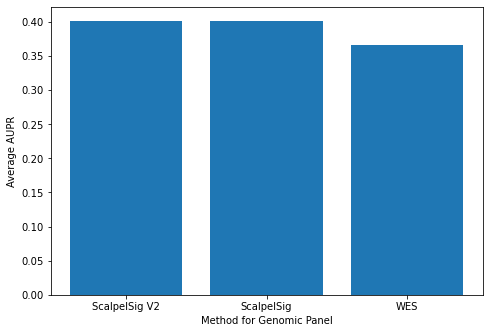

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Method for Genomic Panel')
ax.set_ylabel('Average AUPR')

genomic_panels = ['ScalpelSig V2', 'ScalpelSig', 'WES']
auprs = [get_average_aupr(signature_v2_aupr_dict), get_average_aupr(signature_aupr_dict), get_average_aupr(wes_aupr_dict)]
ax.bar(genomic_panels, auprs)
plt.show()

In [19]:
print('Proportion of data used in ScalpelSig V2 compared to Original ScalpelSig:')
for key, values in scalpelsig_v2_data_usage_dict.items():
    print(key, ':', values)

Proportion of data used in ScalpelSig V2 compared to Original ScalpelSig:
Signature 1 : 0.3090000000000001
Signature 2 : 0.33386666666666664
Signature 3 : 0.26273333333333343
Signature 5 : 0.28493333333333326
Signature 6 : 0.28406666666666663
Signature 8 : 0.2624666666666667
Signature 10 : 0.24999999999999997
Signature 13 : 0.3346
Signature 17 : 0.2551333333333333
Signature 18 : 0.2521333333333334
Signature 20 : 0.26586666666666664
Signature 26 : 0.37979999999999997
Signature 30 : 0.29433333333333334


In [20]:
print('Original ScalpelSig AUPRs')
for key,values in signature_aupr_dict.items():
    print(key, ':', values)

print()
print('ScalpelSig V2 AUPRs')
for key, values in signature_v2_aupr_dict.items():
    print(key, ':', values)

Original ScalpelSig AUPRs
Signature 1 : 0.9073862564807721
Signature 2 : 0.6269126718939678
Signature 3 : 0.6593146565644725
Signature 5 : 0.969284354794436
Signature 6 : 0.09674603174603173
Signature 8 : 0.9049845423394051
Signature 10 : 0.003571428571428571
Signature 13 : 0.6564655307655621
Signature 17 : 0.010714285714285713
Signature 18 : 0.11547619047619048
Signature 20 : 0.008333333333333333
Signature 26 : 0.022331446089616028
Signature 30 : 0.24105709250807292

ScalpelSig V2 AUPRs
Signature 1 : 0.9073862564807721
Signature 2 : 0.6269126718939678
Signature 3 : 0.6593146565644725
Signature 5 : 0.969284354794436
Signature 6 : 0.09674603174603173
Signature 8 : 0.9049845423394051
Signature 10 : 0.003571428571428571
Signature 13 : 0.6564655307655621
Signature 17 : 0.010714285714285713
Signature 18 : 0.11547619047619048
Signature 20 : 0.008333333333333333
Signature 26 : 0.022331446089616028
Signature 30 : 0.24105709250807292


In [21]:
print('WES AUPRs')
for key, values in wes_aupr_dict.items():
    print(key, ':', values)

WES AUPRs
Signature 1 : 0.8618393086384606
Signature 2 : 0.44448332751551967
Signature 3 : 0.5494891393277653
Signature 5 : 0.9439109362294712
Signature 6 : 0.053384208384208376
Signature 8 : 0.890668763924584
Signature 10 : 0.003571428571428571
Signature 13 : 0.49753057906642406
Signature 17 : 0.010714285714285713
Signature 18 : 0.13959647847743084
Signature 20 : 0.0392857142857143
Signature 26 : 0.024999999999999998
Signature 30 : 0.29007626749223386
